<a href="https://colab.research.google.com/github/nualapennycook/Shape-Project-Colab/blob/main/shape_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test loss before training 998.9488525390625
Epoch 0: train loss: 670.109375
Epoch 1: train loss: 420.5325012207031
Epoch 2: train loss: 119.27581024169922
Epoch 3: train loss: 97.70391082763672
Epoch 4: train loss: 88.68175506591797
Epoch 5: train loss: 82.37407684326172
Epoch 6: train loss: 76.87080383300781
Epoch 7: train loss: 82.39656829833984
Epoch 8: train loss: 72.18978118896484
Epoch 9: train loss: 66.25448608398438
Epoch 10: train loss: 63.31416702270508
Epoch 11: train loss: 61.781822204589844
Epoch 12: train loss: 60.598350524902344
Epoch 13: train loss: 56.67528533935547
Epoch 14: train loss: 56.35816192626953
Epoch 15: train loss: 58.69535827636719
Epoch 16: train loss: 63.36177444458008
Epoch 17: train loss: 59.25960159301758
Epoch 18: train loss: 56.12864303588867
Epoch 19: train loss: 52.167049407958984
Epoch 20: train loss: 49.509342193603516
Epoch 21: train loss: 47.28006362915039
Epoch 22: train loss: 48.64064407348633
Epoch 23: train loss: 50.5723762512207
Epoch 24:

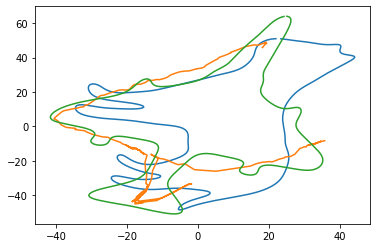

In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from typing import List

'''
Class to read in shape data from text files.
'''
class RegisterShapeData:

    def __init__(self, path_to_shape_data) -> None:
        self.path_to_shape_data = path_to_shape_data
        self.shape_data = []

        self.centred_shape_data = []
        self.x_mean = None
        self.y_mean = None

        self.centred_scaled_data = []

        self.num_of_points = None

    def extract_shape_data(self) -> None:
        '''
        Method to extract shape data from text files as a list of x and y coordinates
        Sets the self.shape_data attribute as a list of x coords and a list of y coords
        '''
        with open(self.path_to_shape_data) as file:
            for line in file:
                self.shape_data.append(line)

            # Formatting the x coordinate data
            # Reads as single character strings, so concatenate the whole line
            self.shape_data[0] = ''.join(self.shape_data[0])
            # Then split according to spacing 
            self.shape_data[0] = self.shape_data[0].split(' ')
            # Convert to strings to floats
            self.shape_data[0] = [float(value.replace('-', '-')) for value in self.shape_data[0]]

            # Do the same for y
            self.shape_data[1] = ''.join(self.shape_data[1])
            # Then split according to spacing 
            self.shape_data[1] = self.shape_data[1].split(' ')
            # Convert to strings to floats
            self.shape_data[1] = [float(value.replace('-', '-')) for value in self.shape_data[1]]

        return 

    def centre_shape(self) -> None:
        '''
        Method to centre shape data about the origin using the translation method for 
        Procrustles alignment.
        Sets the self.centred_shape_data param with the centred x and y coordinates.
        '''
        self.num_of_points = len(self.shape_data[1])

        # Compute mean of x coords and y coords
        self.x_mean = sum(self.shape_data[0])/self.num_of_points
        self.y_mean = sum(self.shape_data[1])/self.num_of_points

        self.centred_shape_data = self.shape_data

        # Centre x and y coords in relation to the mean
        for i in range(self.num_of_points):
            self.centred_shape_data[0][i] = self.centred_shape_data[0][i] - self.x_mean
            self.centred_shape_data[1][i] = self.centred_shape_data[1][i] - self.y_mean
        
        return

    def scale_shape(self) -> None:
        if self.centred_shape_data == []:
            raise ValueError("Data not yet centred, please call self.centre_shape method first.")
        else:
            squared_coords = [coord**2 for coord in self.centred_shape_data[0] and self.centred_shape_data[1]]

            scale_param = (sum(squared_coords))**(1/2)/self.num_of_points

            self.centred_scaled_data = [[coord/scale_param for coord in self.centred_shape_data[0]], [coord/scale_param for coord in self.centred_shape_data[1]]]

        return

def rotate_shape(rotate_data: List, fixed_data: List) -> List:
    '''
    Function to rotate one set of shape data to minimise the distance beween points of another
    set of shape data.
    :param rotate_data: List,  The data to be rotated in the form of a list of x coordinates
    and a list of y coordinates.
    :param fixed_data: List, The fixed data to rotate the shape to in order to minimise the
    sum of the squared distance between the shapes.
    return: List, The rotated rotate_data.
    '''
    num_of_coords = len(rotate_data[0])

    angle_of_rotation = np.arctan((sum([rotate_data[0][i]*fixed_data[1][i] - rotate_data[1][i]*fixed_data[0][i] for i in range(len(rotate_data[0]))]))/
    (sum([rotate_data[0][i]*fixed_data[0][i] + rotate_data[1][i]*fixed_data[1][i] for i in range(num_of_coords)])))

    cos_angle_of_rotation = np.cos(angle_of_rotation)
    sin_angle_of_rotation = np.sin(angle_of_rotation)

    return [[cos_angle_of_rotation*rotate_data[0][i] - sin_angle_of_rotation*rotate_data[1][i] for i in range(num_of_coords)],
    [sin_angle_of_rotation*rotate_data[0][i] + cos_angle_of_rotation*rotate_data[1][i] for i in range(num_of_coords)]]


class Feedforward(torch.nn.Module):
    '''
    This class defines the basic structure of the pytorch neural network.
    This feed forward neural network has one hidden layer.
    This class is taken and modified from: https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb.
    '''

    def __init__(self, input_size: int, hidden_size: int):
        '''
        :param input_size: number of neurons of the input layer.
        :param hidden_size: number of neurons in the hidden layer.
        '''
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc15 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        # Defining the output size of the output 
        self.fc2 = torch.nn.Linear(self.hidden_size, 2)
        self.sigmoid = torch.nn.Sigmoid()
             
    def forward(self, x):
        hidden1 = self.fc1(x)
        hidden2 = self.fc15(hidden1)
        relu = self.tanh(hidden2)
        output = self.fc2(relu)
        # output = self.sigmoid(output)
        return output

# Firstly need to extract the training data from the text files
# We train the network for a set shape to another set shape
input_data = RegisterShapeData(path_to_shape_data='/content/drive/MyDrive/Colab Notebooks/shape_landmark_data/train_data/cat.txt')
input_data.extract_shape_data()
input_data.centre_shape()
input_data.scale_shape()

set_data = RegisterShapeData(path_to_shape_data='/content/drive/MyDrive/Colab Notebooks/shape_landmark_data/train_data/plane.txt')
set_data.extract_shape_data()
set_data.centre_shape()
set_data.scale_shape()

# Rotating the input data to the orientation of the set data
x_data = rotate_shape(rotate_data=input_data.shape_data, fixed_data=set_data.shape_data)

# Plotting the input data before it is reshaped
fig, ax = plt.subplots()
ax.plot(x_data[0], x_data[1])
line, = ax.plot(x_data[0], x_data[1])
ax.plot(set_data.shape_data[0], set_data.shape_data[1])

# Reorgainising/reshaping the data into pairs
x_data = [[x_data[0][i], x_data[1][i]] for i in range(len(x_data[0]))]
y_data = [[set_data.shape_data[0][i], set_data.shape_data[1][i]] for i in range(len(set_data.shape_data[0]))]

# Splitting the data into test and train sets
# 250 coords for the training and 50 for the test
x_train = x_data[:250]
x_test = x_data[250:]
y_train = y_data[:250]
y_test = y_data[250:]

# Now convert x and y to pytorch tensors
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

# Initialising the FeedFoward neural network from the class definition
shape_model = Feedforward(2, 300)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(shape_model.parameters(), lr=0.01)

# Testing the model performance before training
shape_model.eval()
y_pred = shape_model(x_test)
before_train = criterion(y_pred.squeeze(), y_test)
print('Test loss before training', before_train.item())

collect_train_pred = []

# Training the model
shape_model.train()
epoch = 100
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_train_pred = shape_model(x_train)
    collect_train_pred.append(y_train_pred)
    # Compute Loss
    loss = criterion(y_train_pred.squeeze(), y_train)
   
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

# Performance after training
shape_model.eval()
y_test_pred = shape_model(x_test)
after_train = criterion(y_test_pred.squeeze(), y_test) 
print('Test loss after Training' , after_train.item())


## Animation of the training
# Reshaped y_pred for plotting
y_train_pred_list = y_train_pred.tolist()
reshaped_y_pred = [[y_train_pred_list[i][0] for i in range(250)], [y_train_pred_list[i][1] for i in range(250)]]

for i in range(len(collect_train_pred)):
    data_epoch = collect_train_pred[i].tolist()
    collect_train_pred[i] = [[data_epoch[i][0] for i in range(250)], [data_epoch[i][1] for i in range(250)]]

def animate_shape(i):
    line.set_data(collect_train_pred[i][0], collect_train_pred[i][1])
    return line,

anim = FuncAnimation(fig, animate_shape,
                     frames = epoch, interval = 20, blit = True)

writervideo = PillowWriter(fps = 10)
    
anim.save('cat_to_plane.gif', 
          writer = writervideo)


# plt.plot(reshaped_y_pred[0], reshaped_y_pred[1])
# plt.xlim([-60, 70])
# plt.ylim([-60, 70])
# plt.show()